In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from sklearn import linear_model

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<br>

# Data

$$ y_t \equiv \log{y_t} $$
$$ y_t = a + bt + \varepsilon_t$$


$$ \text{secular trend: } \quad y_t^s = a + bt$$
$$ \text{cycle: } \quad y_t^c = \varepsilon_t$$

In [5]:
fed_y = pd.read_csv("./A939RX0Q048SBEA.csv"); fed_y.set_index("DATE", inplace=True); yh = fed_y.A939RX0Q048SBEA.values

In [6]:
X = [i for i in range(0, len(yh))]
X = np.reshape(X, (len(X), 1))
model = linear_model.LinearRegression()
model.fit(X, np.log(yh))
# calculate trend
trend = model.predict(X)

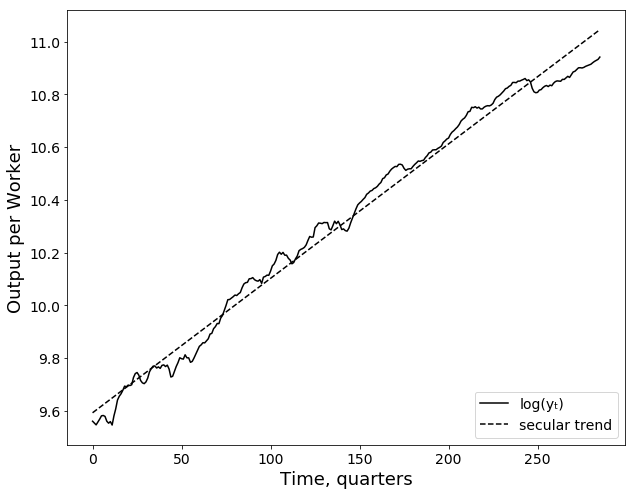

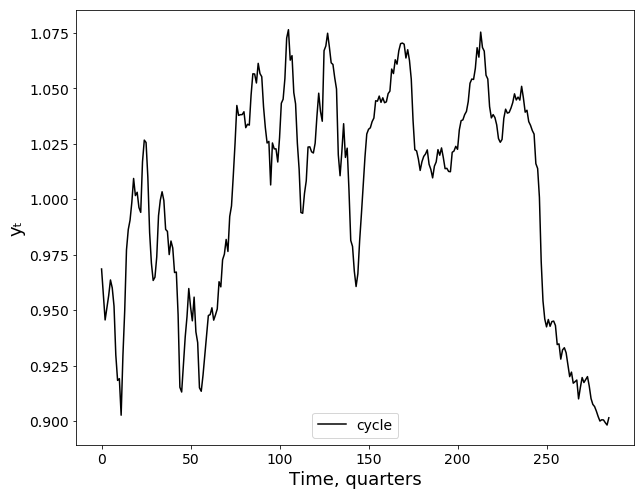

In [7]:
# plot trend
plt.figure(figsize=(10,8))
plt.plot(range(0,len(yh)),np.log(yh), 'black', label='log(yₜ)')
plt.plot(range(0,len(yh)),trend, 'black', linestyle = "--", label='secular trend')
plt.legend(loc='lower right')
plt.xlabel("Time, quarters")
plt.ylabel("Output per Worker")
plt.show()

# detrend
yh_cycle = [np.log(yh[i])-trend[i] for i in range(0, len(yh))]
# plot detrended
plt.figure(figsize=(10,8))
plt.plot(np.exp(yh_cycle), 'black', label='cycle')
#plt.plot(yh_cycle/np.mean(yh_cycle), linestyle = "--", label='cycle normalized')
plt.legend(loc='lower center')
plt.xlabel("Time, quarters")
plt.ylabel("yₜ")
plt.show()

<br>

# Model

In [139]:
def solow_swan(t, n, s, δ, α, A, ɛ, λ0, γ, k0, σ, crisis):
    """
    A Stochastic, Discrete-Time Solow-Swan Model
    
    Inputs
    ------
      t:            number of periods
      n:            population growth rate
      s:            savings rate
      δ:            depreciation rate
      α:            capital income share 
      A:            technology constant
      ɛ:            stochastic process 
      s:            standard deviation of shock to total factor productivity (TFP)
    
    Outputs
    -------
    - Exact
      ke            capital per income
      ke_tilda:     capital per income, log deviations
      γe:           vdsv
      ye:           dvss
      λe:           csd
    - Approximation
      ke            vds
      ke_tilda:     vsd
      γe:           vdsv
      ye:           dvss
      λe:           csd
    """   
    s=3*(δ+n)
    k_ss = ((s)/(δ+n))**(1/(1-α)); k0 = k_ss
    y_ss = k_ss**α
    
    # Shocks
    log_λ = np.empty(t); log_λ[0] = np.log(λ0)
    for i in range(0,t-1): 
        if i == 40 and crisis==True:
            log_λ[i+1] = γ*log_λ[i]-0.15#np.abs(ɛ[i]*σ)*15
        else:
            log_λ[i+1] = γ*log_λ[i]+ɛ[i]*σ 
 
    λ_tilda = log_λ
    λ = np.exp(log_λ)
    
    
    # exact solution
    ke = np.empty(t); ke[0] = k_ss#k0  
    for i in range(0,t-1): ke[i+1] = ((1-δ)*ke[i]+s*λ[i]*(ke[i]**α))/(1+n)
    
    # approximate solution
    B = (1+α*n-δ*(1-α))/(1+n)
    C = (δ+n)/(1+n)
    #ka_tilda = np.empty(t); ka_tilda[0] = np.log(k0)-np.log(k_ss)
    ka_tilda = np.zeros(t)
    for i in range(0,t-1): ka_tilda[i+1] = C*np.sum(np.multiply(np.power(np.repeat(B, i+1), range(0,i+1)),np.flip(λ_tilda[:i+1])))+(B**(i+1))*ka_tilda[0]
    
    # return
    ye = np.multiply(λ, np.power(ke,α))
    ka = np.exp(ka_tilda+np.log(k_ss))
    ya_tilda = np.multiply(α, ka_tilda)+log_λ
    ya = np.exp(ya_tilda+np.log(y_ss))

    return(
        [ke, ye],
        [ka, ya],
        y_ss
    )

<br>

In [128]:
t = len(yh); n = 0.0045; δ = 1.1**(1/4)-1; α = 1/3; s = 3 * (δ + n)
A = 1; ɛ = np.random.randn(t);

In [140]:
exact, approx, y_ss = solow_swan(t, n, s, δ, α, A, ɛ, 1, .95, 1, 0.2, False)
ke, ye = exact
ka, ya = approx

<br>

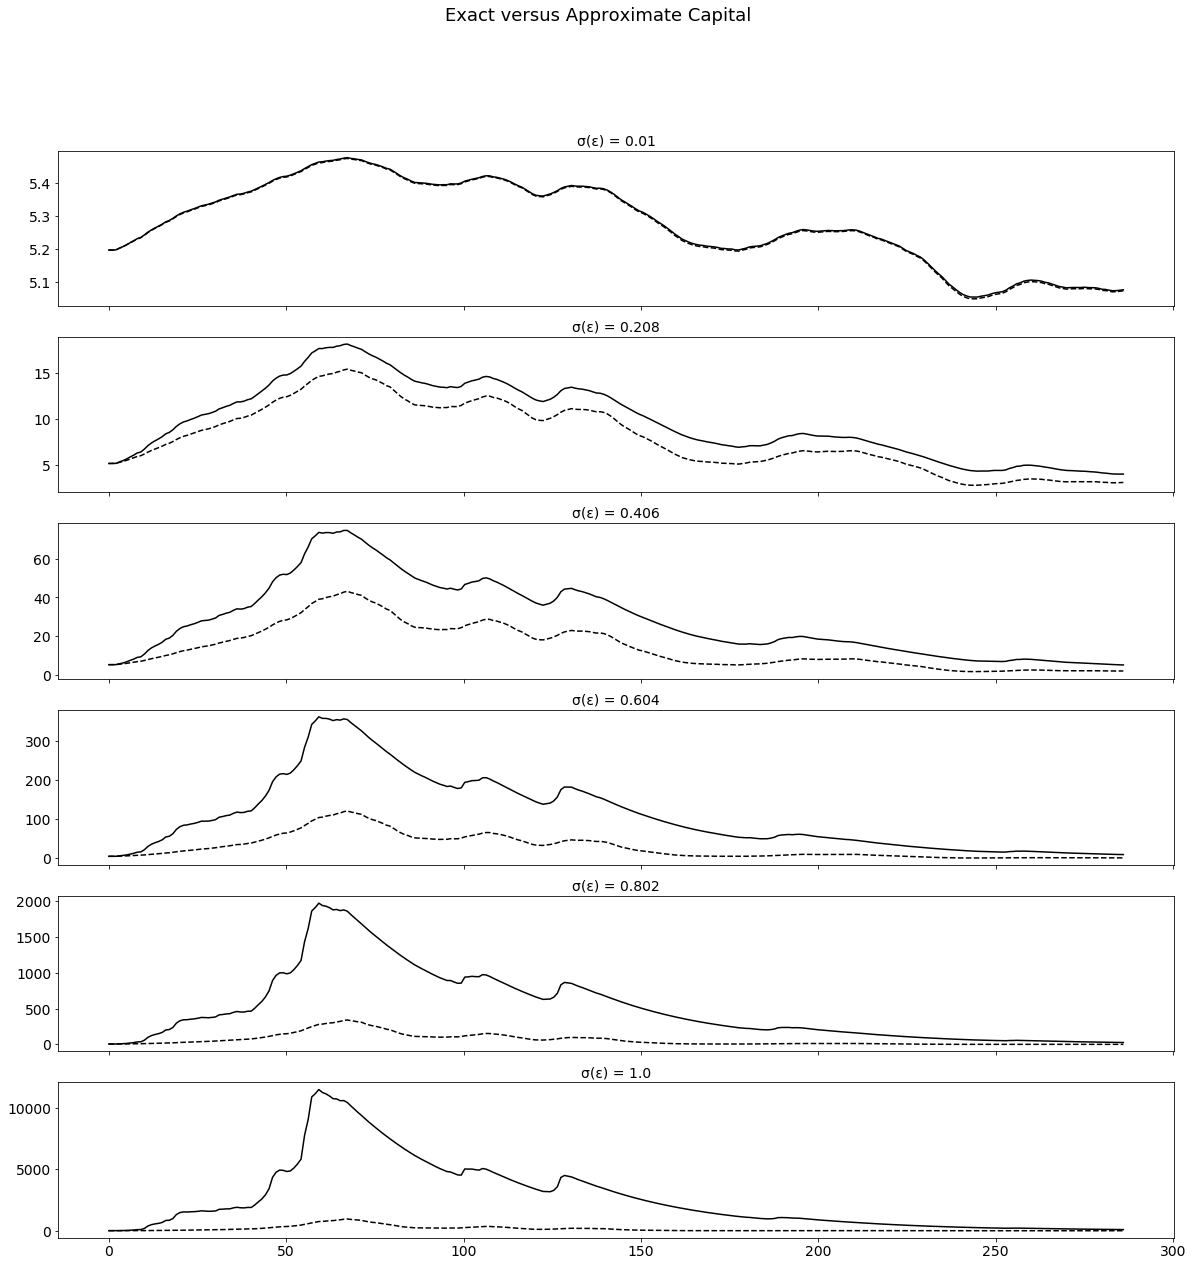

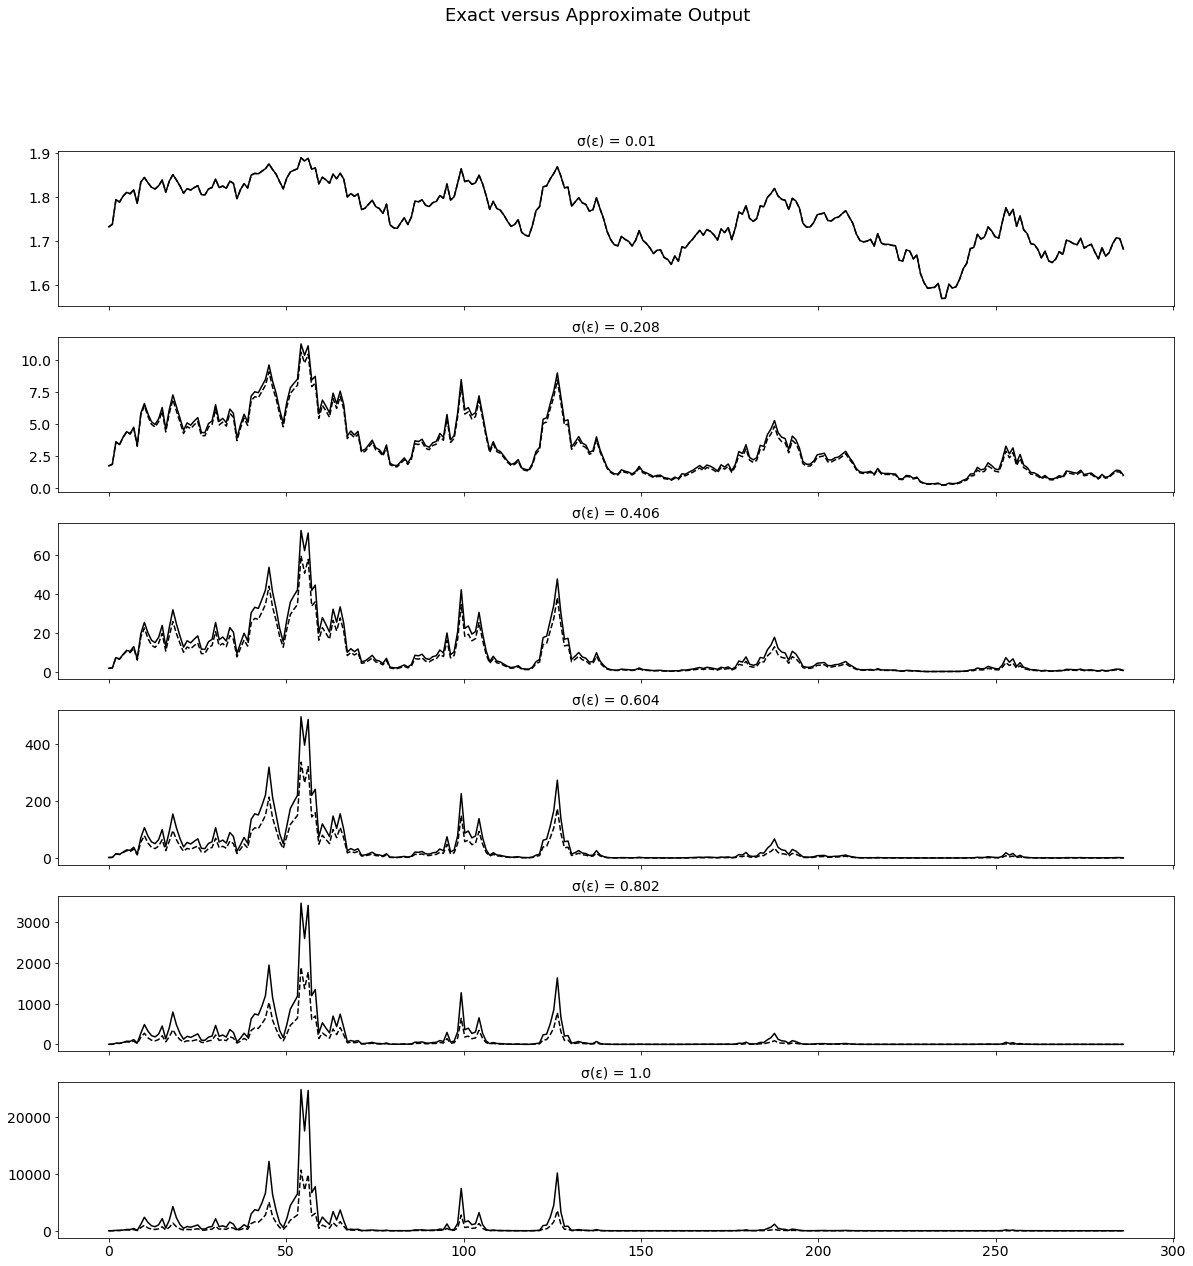

In [141]:
f, axarr = plt.subplots(6, sharex=True, figsize=(20,20))
f.suptitle('Exact versus Approximate Capital')
xaxis = np.linspace(0, t, t)
for i, σ in enumerate(np.linspace(0.01, 1, 6)):
    axarr[i].set_title("σ(ɛ) = "+str(round(σ,4)))
    exact_temp, approx_temp,_ = solow_swan(t, n, s, δ, α, A, ɛ, 1, .95, 1, σ, False)
    ke_temp, _ = exact_temp
    ka_temp, _ = approx_temp
    axarr[i].plot(xaxis, ke_temp, 'black')
    axarr[i].plot(xaxis, ka_temp, 'black', linestyle = "--")
plt.show()

f, axarr = plt.subplots(6, sharex=True, figsize=(20,20))
f.suptitle('Exact versus Approximate Output')
xaxis = np.linspace(0, t, t)
for i, σ in enumerate(np.linspace(0.01, 1, 6)):
    axarr[i].set_title("σ(ɛ) = "+str(round(σ,4)))
    exact_temp, approx_temp,_ = solow_swan(t, n, s, δ, α, A, ɛ, 1, .95, 1, σ, False)
    _, ye_temp = exact_temp
    _, ya_temp = approx_temp
    axarr[i].plot(xaxis, ye_temp, 'black')
    axarr[i].plot(xaxis, ya_temp, 'black', linestyle = "--")
plt.show()

<br>

# Calibration

In [142]:
sdh = np.std(np.exp(yh_cycle)*y_ss)
def g(se): return np.var(solow_swan(t, n, s, δ, α, A, ɛ, 1, .95, _, se, False)[0][1]) - sdh**2
sr = brentq(g, 0, 0.1)
print(sdh, sr)

0.0854307965134957 0.012266139305240191


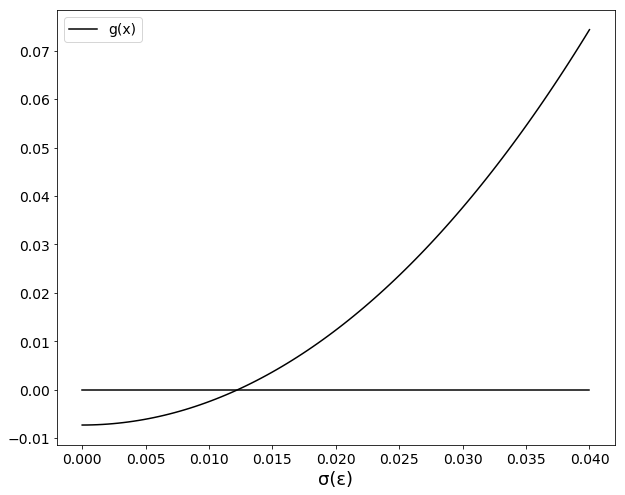

In [143]:
soi = np.linspace(0, .04, 100)
plt.figure(figsize=(10,8))
plt.plot(soi, soi*0, 'black')
plt.plot(soi, [g(i) for i in soi], 'black', label='g(x)')
plt.legend(loc='upper left')
plt.xlabel("σ(ɛ)")
plt.show()

$\cdot$

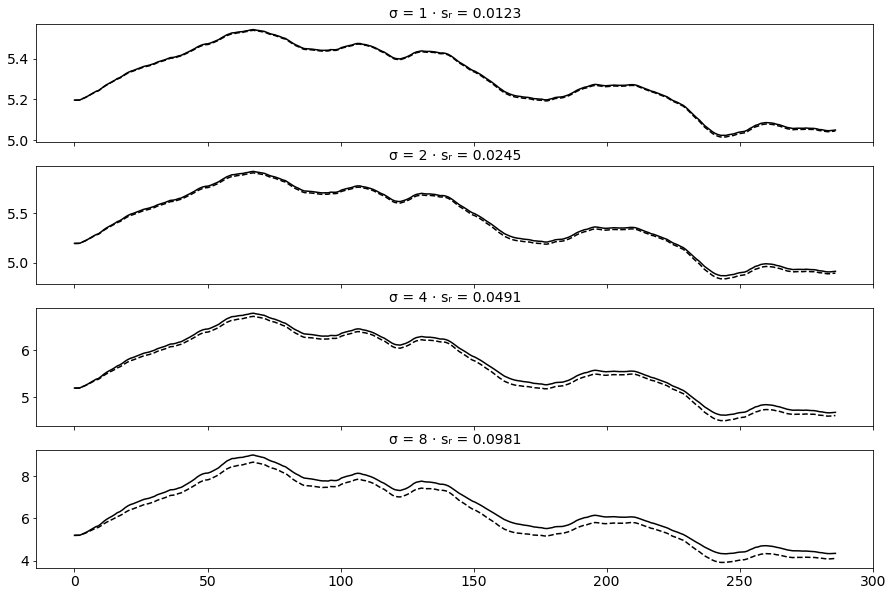

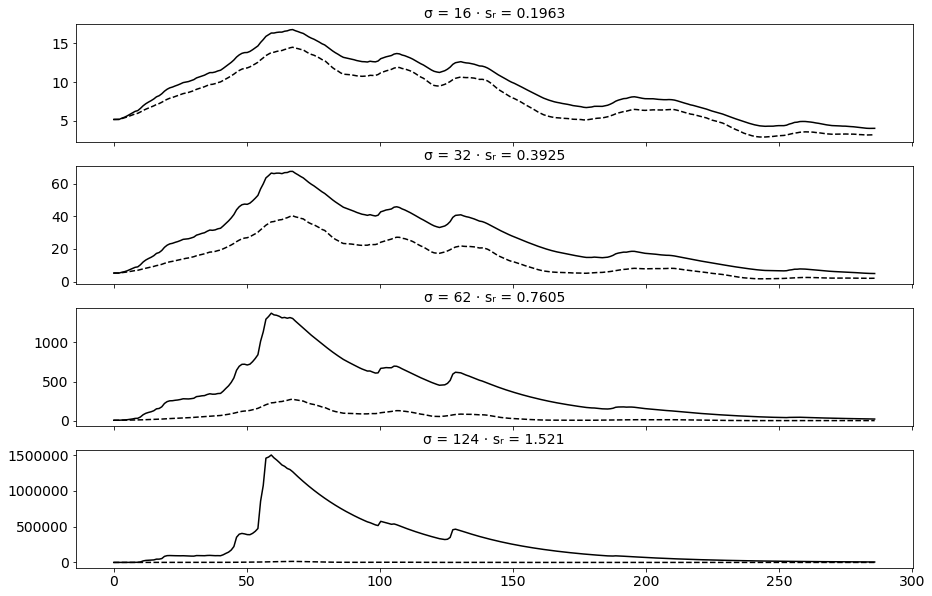

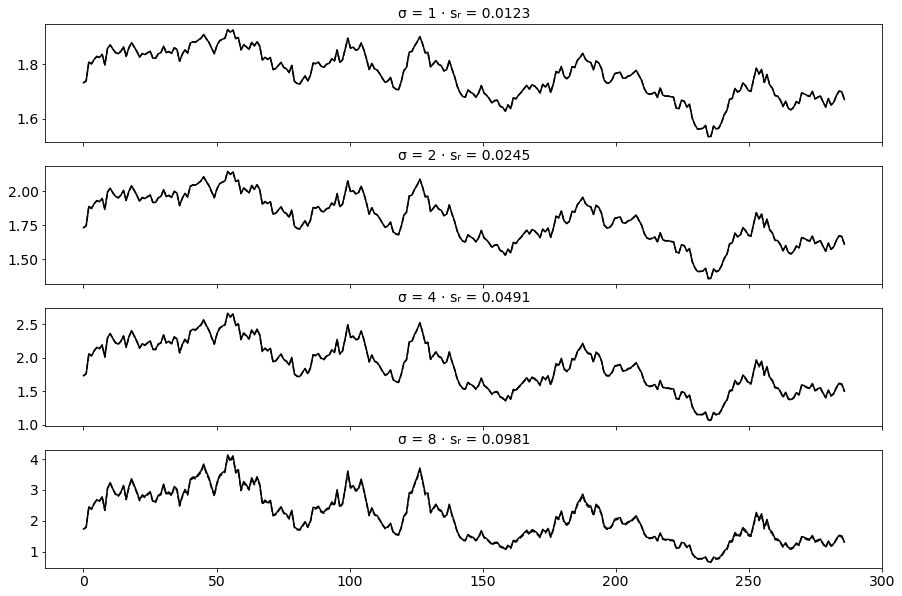

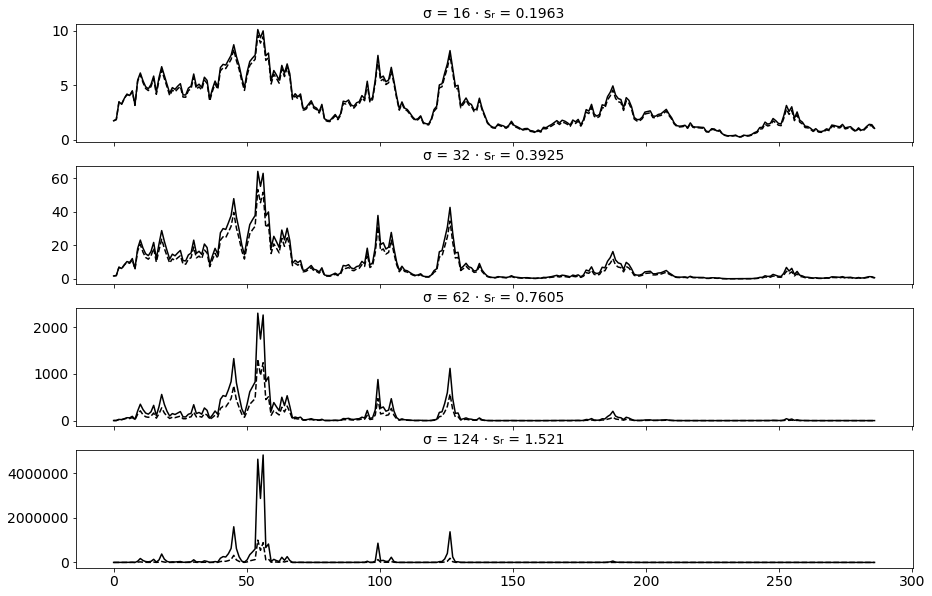

In [177]:
f, axarr = plt.subplots(4, sharex=True, figsize=(15, 10))
xaxis = np.linspace(0, t, t)
for i, σ in enumerate([1, 2, 4, 8]):
    axarr[i].set_title("σ = "+str(σ)+" ⋅ sᵣ = "+str(round(σ*sr,4)))
    exact_temp, approx_temp,_ = solow_swan(t, n, s, δ, α, A, ɛ, 1, .95, 1, σ*sr, False)
    ke_temp, _ = exact_temp
    ka_temp, _ = approx_temp
    axarr[i].plot(xaxis, ke_temp, 'black')
    axarr[i].plot(xaxis, ka_temp, 'black', linestyle = "--")
plt.show()

f, axarr = plt.subplots(4, sharex=True, figsize=(15, 10))
xaxis = np.linspace(0, t, t)
for i, σ in enumerate([16, 32, 62, 124]):
    axarr[i].set_title("σ = "+str(σ)+" ⋅ sᵣ = "+str(round(σ*sr,4)))
    exact_temp, approx_temp,_ = solow_swan(t, n, s, δ, α, A, ɛ, 1, .95, 1, σ*sr, False)
    ke_temp, _ = exact_temp
    ka_temp, _ = approx_temp
    axarr[i].plot(xaxis, ke_temp, 'black')
    axarr[i].plot(xaxis, ka_temp, 'black', linestyle = "--")
plt.show()

f, axarr = plt.subplots(4, sharex=True, figsize=(15, 10))
xaxis = np.linspace(0, t, t)
for i, σ in enumerate([1, 2, 4, 8]):
    axarr[i].set_title("σ = "+str(σ)+" ⋅ sᵣ = "+str(round(σ*sr,4)))
    exact_temp, approx_temp,_ = solow_swan(t, n, s, δ, α, A, ɛ, 1, .95, 1, σ*sr, False)
    _, ye_temp = exact_temp
    _, ya_temp = approx_temp
    axarr[i].plot(xaxis, ye_temp, 'black')
    axarr[i].plot(xaxis, ya_temp, 'black', linestyle = "--")
plt.show()

f, axarr = plt.subplots(4, sharex=True, figsize=(15, 10))
xaxis = np.linspace(0, t, t)
for i, σ in enumerate([16, 32, 62, 124]):
    axarr[i].set_title("σ = "+str(σ)+" ⋅ sᵣ = "+str(round(σ*sr,4)))
    exact_temp, approx_temp,_ = solow_swan(t, n, s, δ, α, A, ɛ, 1, .95, 1, σ*sr, False)
    _, ye_temp = exact_temp
    _, ya_temp = approx_temp
    axarr[i].plot(xaxis, ye_temp, 'black')
    axarr[i].plot(xaxis, ya_temp, 'black', linestyle = "--")
plt.show()

<br>

# Visualizations - No Crisis

In [144]:
exact, approx, y_ss = solow_swan(t, n, s, δ, α, A, ɛ, 1, .95, 1, sr, crisis=False)
ke, ye = exact
ka, ya = approx

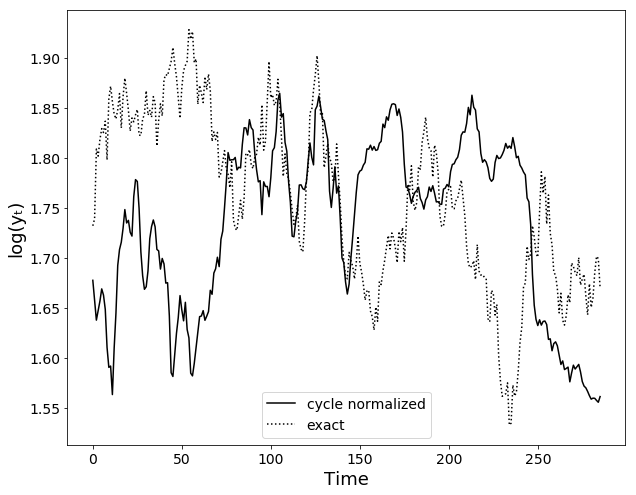

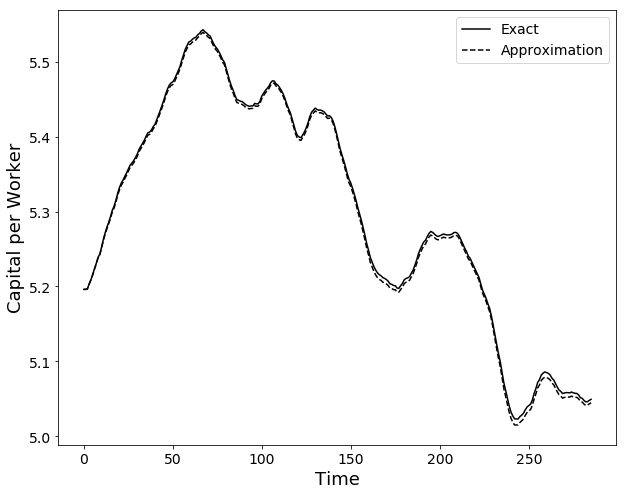

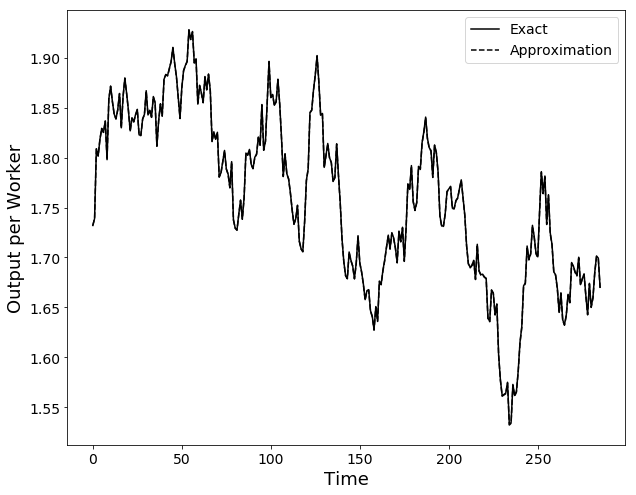

In [146]:
xaxis = range(0, t)

plt.figure(figsize=(10,8))
plt.plot(xaxis, np.exp(yh_cycle)*y_ss,"black",  label='cycle normalized')
plt.plot(xaxis, ye, "black", linestyle = ":", label='exact')
plt.legend(loc='lower center')
plt.xlabel("Time")
plt.ylabel("log(yₜ)")
plt.show()

plt.figure(figsize=(10,8))
plt.plot(xaxis, ke, 'black', label='Exact')
plt.plot(xaxis, ka, 'black', linestyle = "--", label='Approximation')
plt.legend(loc='upper right')
plt.ylabel("Capital per Worker")
plt.xlabel("Time")
plt.show()

plt.figure(figsize=(10,8))
plt.plot(xaxis, ye, 'black', label='Exact')
plt.plot(xaxis, ya, 'black', linestyle = "--", label='Approximation')
plt.legend(loc='upper right')
plt.ylabel("Output per Worker")
plt.xlabel("Time")
plt.show()

# Visualizations - Crisis

In [147]:
exact, approx, y_ss = solow_swan(t, n, s, δ, α, A, ɛ, 1, .95, 1, sr, crisis=True)
ke, ye = exact
ka, ya = approx

In [148]:
np.mean(np.exp(yh_cycle)*y_ss), np.mean(ye)

(1.734196016962847, 1.7316785672097397)

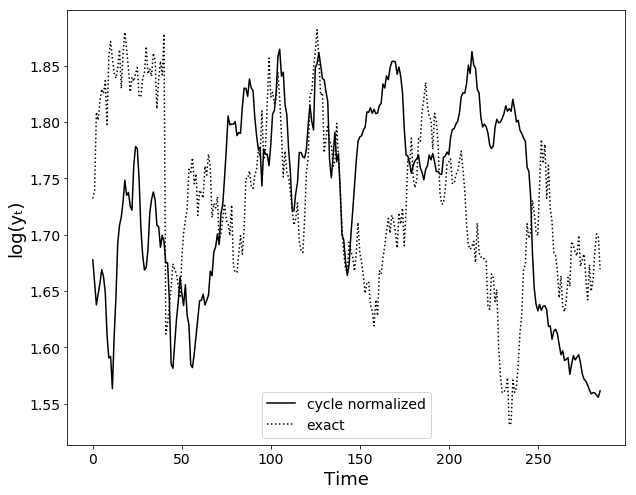

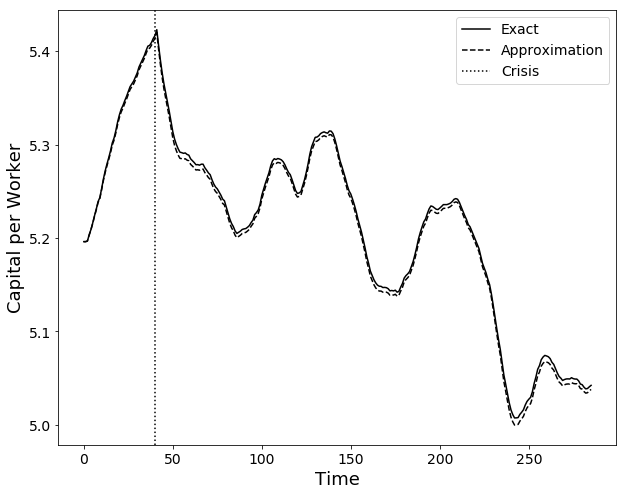

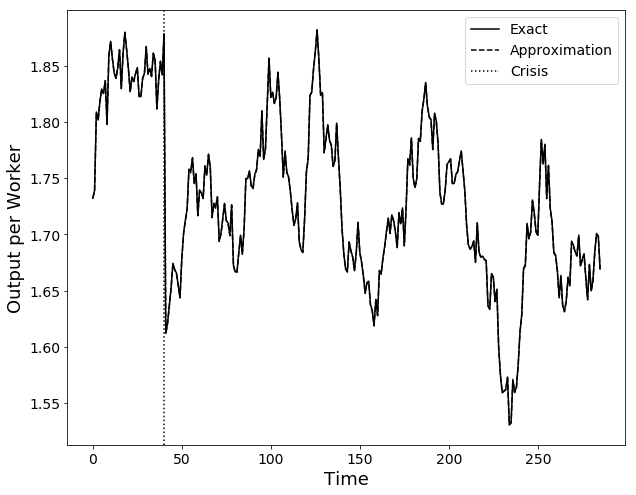

In [149]:
xaxis = range(0, t)

plt.figure(figsize=(10,8))
plt.plot(xaxis, np.exp(yh_cycle)*y_ss,"black",  label='cycle normalized')
plt.plot(xaxis, ye, "black", linestyle = ":", label='exact')
plt.legend(loc='lower center')
plt.xlabel("Time")
plt.ylabel("log(yₜ)")
plt.show()

plt.figure(figsize=(10,8))
plt.plot(xaxis, ke, 'black', label='Exact')
plt.plot(xaxis, ka, 'black', linestyle = "--", label='Approximation')
plt.axvline(x=40, color="black", linestyle = ":", label='Crisis')
plt.legend(loc='upper right')
plt.ylabel("Capital per Worker")
plt.xlabel("Time")
plt.show()

plt.figure(figsize=(10,8))
plt.plot(xaxis, ye, 'black', label='Exact')
plt.plot(xaxis, ya, 'black', linestyle = "--", label='Approximation')
plt.axvline(x=40, color="black", linestyle = ":", label='Crisis')
plt.legend(loc='upper right')
plt.ylabel("Output per Worker")
plt.xlabel("Time")
plt.show()

<br>